In [87]:
import tensorflow as tf
import keras
from keras import layers
import keras_tuner as kt
import time

In [88]:
tf.get_logger().setLevel('ERROR')

In [89]:
import sys
from PIL import Image
sys.modules['Image'] = Image 

In [90]:
import os

# folders = ("H", "S", "U", "FG", "OP", "P", "C")
folders = ("H", "S", "U")

num_skipped = 0
for folder_name in folders:
    folder_path = os.path.join("Signs", folder_name)
    for fname in os.listdir(folder_path):
        fpath = os.path.join(folder_path, fname)
        try:
            fobj = open(fpath, "rb")
            is_jfif = tf.compat.as_bytes("PNG") in fobj.peek(10)
        finally:
            fobj.close()

        if not is_jfif:
            num_skipped += 1
            # Delete corrupted image
            os.remove(fpath)

print("Deleted %d images" % num_skipped)

Deleted 0 images


In [91]:
image_size = (64, 40)
batch_size = 32

train_ds = keras.utils.image_dataset_from_directory(
    "Signs",
    validation_split=0.2,
    subset="training",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)

val_ds = keras.utils.image_dataset_from_directory(
    "Signs",
    validation_split=0.2,
    subset="validation",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)

Found 6228 files belonging to 3 classes.
Using 4983 files for training.
Found 6228 files belonging to 3 classes.
Using 1245 files for validation.


In [92]:
class_names = train_ds.class_names
print(class_names)

['H', 'S', 'U']


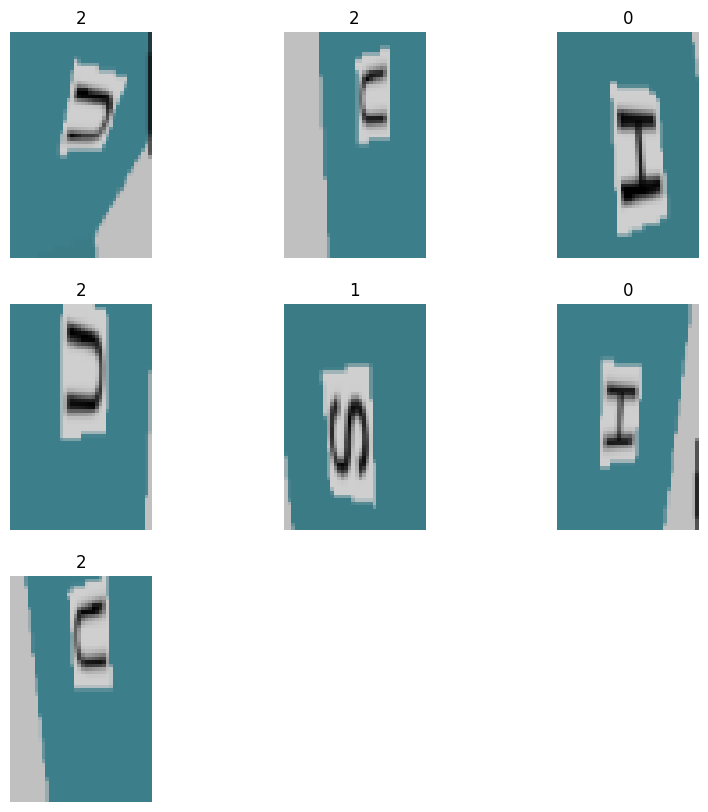

In [93]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(7):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

In [94]:
data_augmentation = keras.Sequential(
    [
        layers.RandomTranslation(height_factor=0.2, width_factor=0.2, fill_mode="constant"),
        layers.RandomFlip("horizontal",
                      input_shape=image_size + (3,)),
        layers.RandomZoom(.2, .2),
    ]
)

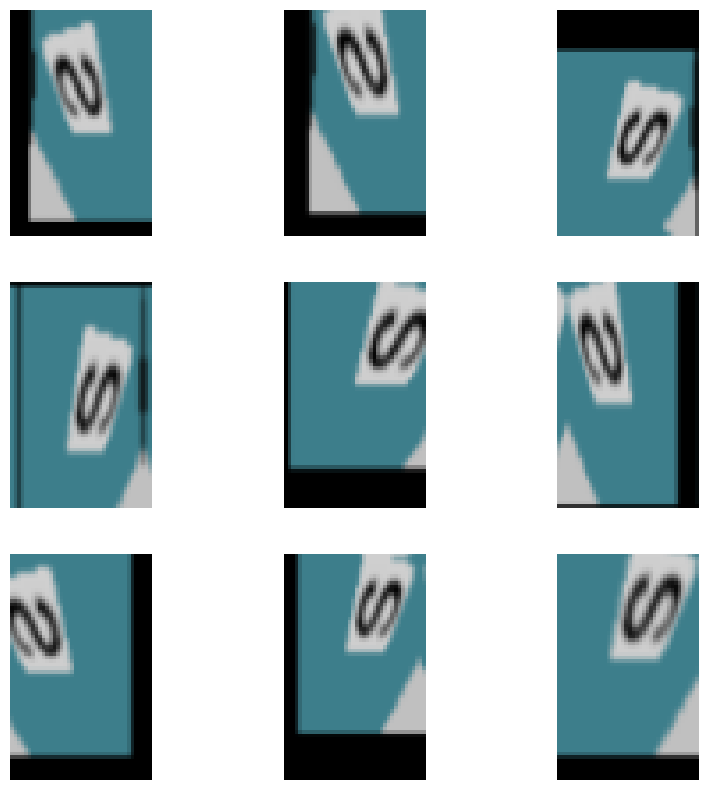

In [95]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

In [73]:
# Apply `data_augmentation` to the training images.
train_ds = train_ds.map(
    lambda img, label: (data_augmentation(img), label),
    num_parallel_calls=tf.data.AUTOTUNE,
)
# Prefetching samples in GPU memory helps maximize GPU utilization.
train_ds = train_ds.prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.prefetch(tf.data.AUTOTUNE)

In [96]:
input_shape=image_size + (3,)
num_classes=len(folders)

In [97]:
def model_builder(hp):
    hp_units = hp.Int('units', min_value=32, max_value=512, step=32)

    model = keras.Sequential([
        data_augmentation,
        layers.Rescaling(1./255, input_shape=input_shape),
        layers.Conv2D(16, 3, padding='same', activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(),
        layers.Conv2D(32, 3, padding='same', activation='relu'),
        layers.MaxPooling2D(),
        layers.Conv2D(64, 3, padding='same', activation='relu'),
        layers.MaxPooling2D(),
        layers.Dropout(0.2),
        layers.Flatten(),
        layers.Dense(hp_units, activation='relu'),
        layers.Dense(num_classes, name="outputs")
    ])


    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=['accuracy']
    )

    return model

In [98]:
tuner = kt.Hyperband(
    model_builder,
    objective='val_accuracy',
    max_epochs=10,
    factor=3,
    directory='kt',
    project_name='erebus'
)

In [99]:
stop_early = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

In [100]:
tuner.search(train_ds, validation_data=val_ds, epochs=50, validation_split=0.2, callbacks=[stop_early])

# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is {best_hps.get('units')} and the optimal learning rate for the optimizer
is {best_hps.get('learning_rate')}.
""")

Trial 24 Complete [00h 00m 40s]
val_accuracy: 0.9453815221786499

Best val_accuracy So Far: 0.9959839582443237
Total elapsed time: 00h 06m 53s

The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is 224 and the optimal learning rate for the optimizer
is 0.001.



In [101]:
model = tuner.hypermodel.build(best_hps)
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=50,
    validation_split=0.2
)

Epoch 1/50
156/156 [==============================] - 7s 25ms/step - loss: 0.7702 - accuracy: 0.6089 - val_loss: 0.8028 - val_accuracy: 0.8321
Epoch 2/50
156/156 [==============================] - 4s 25ms/step - loss: 0.2697 - accuracy: 0.8848 - val_loss: 0.3150 - val_accuracy: 0.9791
Epoch 3/50
156/156 [==============================] - 4s 26ms/step - loss: 0.1513 - accuracy: 0.9378 - val_loss: 0.0692 - val_accuracy: 0.9839
Epoch 4/50
156/156 [==============================] - 4s 25ms/step - loss: 0.1177 - accuracy: 0.9518 - val_loss: 0.0568 - val_accuracy: 0.9807
Epoch 5/50
156/156 [==============================] - 4s 25ms/step - loss: 0.1040 - accuracy: 0.9542 - val_loss: 0.0375 - val_accuracy: 0.9815
Epoch 6/50
156/156 [==============================] - 4s 25ms/step - loss: 0.1120 - accuracy: 0.9518 - val_loss: 0.0404 - val_accuracy: 0.9815
Epoch 7/50
156/156 [==============================] - 4s 24ms/step - loss: 0.0879 - accuracy: 0.9639 - val_loss: 0.0181 - val_accuracy: 0.9944

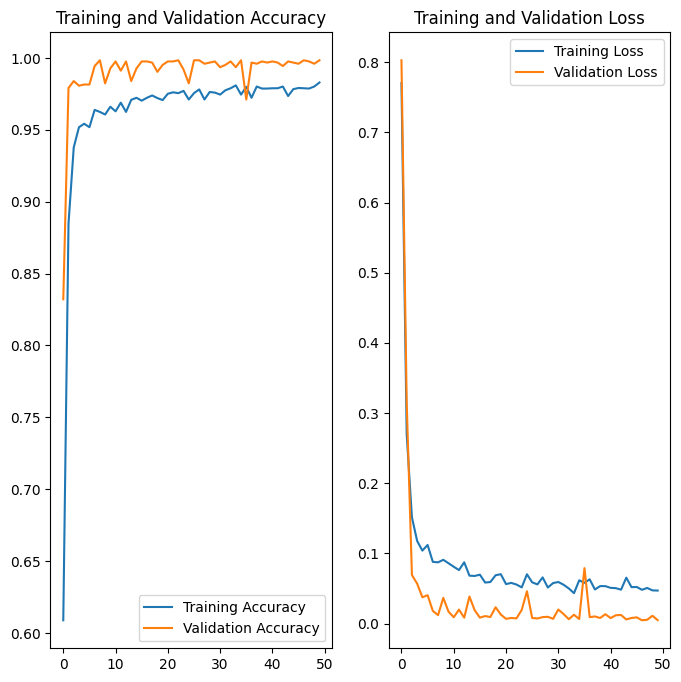

In [102]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(50)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [103]:
model.save('test_2-hp_na.keras')

In [105]:
img = tf.keras.preprocessing.image.load_img(
    "Signs/S/55.png", target_size=image_size
)

In [107]:
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create batch axis

start = time.process_time() 
predictions = model.predict(img_array)
end = time.process_time()

print("Time: {}s".format(end-start)) 
print(list(map(lambda p, c: (c, p),predictions[0], class_names)))

1/1 [==============================] - 0s 43ms/step
Time: 0.06498999999985244s
[('H', -22.770601), ('S', 41.045067), ('U', -23.962883)]
